In [1]:
!git clone https://github.com/M-Jafarkhani/Multimodal-Sentiment-Analysis

Cloning into 'Multimodal-Sentiment-Analysis'...
remote: Enumerating objects: 340, done.
remote: Counting objects: 100% (199/199), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 340 (delta 88), reused 140 (delta 48), pack-reused 141 (from 1)
Receiving objects: 100% (340/340), 279.89 MiB | 16.51 MiB/s, done.
Resolving deltas: 100% (126/126), done.
Updating files: 100% (56/56), done.


In [6]:
!pip install memory_profiler

In [2]:
import gdown

# File ID and destination
file_id = "1szKIqO0t3Be_W91xvf6aYmsVVUa7wDHU"
destination = "mosi_raw.pkl"  # Name to save the file as

# Download the file
gdown.download(
    f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1szKIqO0t3Be_W91xvf6aYmsVVUa7wDHU
From (redirected): https://drive.google.com/uc?id=1szKIqO0t3Be_W91xvf6aYmsVVUa7wDHU&confirm=t&uuid=ba1f6c02-08f8-49a8-b6c4-e4c9daf59915
To: /content/mosi_raw.pkl
100%|██████████| 357M/357M [00:03<00:00, 118MB/s]


'mosi_raw.pkl'

In [3]:
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append('/content/Multimodal-Sentiment-Analysis/src')

In [7]:
from loader import get_dataloader
from unimodals.modules import GRU, MLP
from training.unimodal import train, test
from utils import get_default_device, save_results

In [8]:
traindata, validdata, testdata = get_dataloader(
    '/content/mosi_raw.pkl', max_pad=True, data_type='mosi', max_seq_len=50)

In [9]:
FILE_NAME = 'mosi_uni_r0'

In [10]:
device = get_default_device()
print(device)

cpu


In [11]:
modality_num = 2

encoder = GRU(
    300, 600, dropout=True, has_padding=False, batch_first=True, last_only=True
).to(device)

head = MLP(600, 512, 1).to(device)


In [ ]:
train_losses, valid_losses = train(
    encoder,
    head,
    traindata,
    validdata,
    500,
    task="regression",
    optimtype=torch.optim.AdamW,
    lr=2e-3,
    weight_decay=0.01,
    criterion=torch.nn.L1Loss(),
    save_encoder=f"/content/Multimodal-Sentiment-Analysis/models/{FILE_NAME}_encoder.pt",
    save_head=f"/content/Multimodal-Sentiment-Analysis/models{FILE_NAME}_head.pt",
    modalnum=modality_num,
)


Text(0.5, 1.0, 'Loss vs. No. of epochs')

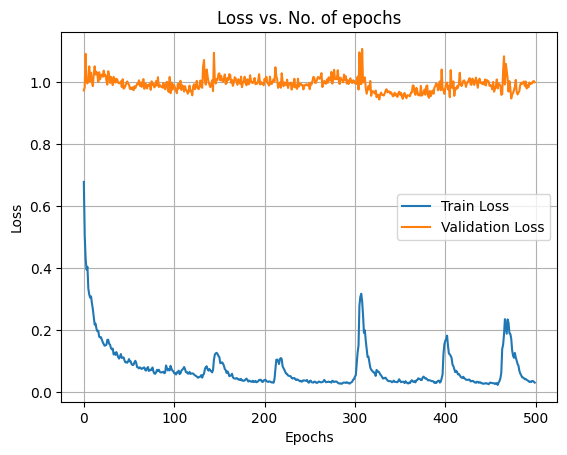

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of epochs')

In [ ]:
save_results(train_losses, valid_losses, f'/content/Multimodal-Sentiment-Analysis/results/{FILE_NAME}.pkl')

In [ ]:
encoder = torch.load(
    f"/content/Multimodal-Sentiment-Analysis/models/{FILE_NAME}_encoder.pt"
).to(device)
head = torch.load(
    f"/content/Multimodal-Sentiment-Analysis/models/{FILE_NAME}_head.pt"
).to(device)

test(
    encoder,
    head,
    testdata,
    criterion=torch.nn.L1Loss(),
    task="posneg-classification",
    modalnum=modality_num,
)